## LTSM Neural Network 

#### By: Parker Christenson 

This is going to the the attempt to get the Long short term memory neural network to work on the data set. I will be using the Keras library to build the model. 

I will be attempting to optimize the model by using a variety of different hyperparameters, and tunning the model to get the best results possible. By doing so, I hope that I will be able to achevive the best results possible. 

### Importing the needed Libraries for Model development

In [34]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf

In [35]:
df = pd.read_csv('Occupancy.csv')
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [36]:
# getting the data types of the columns
df.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

In [37]:
# Checking for missing values
df.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [38]:
# Checking for duplicates
df.duplicated().sum()

0

### We are now going to do some basic feature extraction and data preprocessing. Our goal here is to pull out as much relevant information as possible from the data set, which in theory should help our model perform better

In [39]:
# making a new column called 'time' from the 'date' column 
df['time'] = pd.to_datetime(df['date']).dt.time

In [40]:
# Getting the 'Temperature' and 'Humidity' ratio and making a new column called 'Temp_Hum_Ratio'
df['Temp_Hum_Ratio'] = df['Temperature'] / df['Humidity']
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,time,Temp_Hum_Ratio
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,14:19:00,0.902101
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,14:19:59,0.902168
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,14:21:00,0.904689
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,14:22:00,0.908038
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,14:23:00,0.906641


In [41]:
# getting the weekday from the 'date' column
df['DOTW'] = pd.to_datetime(df['date']).dt.day_name()
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,time,Temp_Hum_Ratio,DOTW
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,14:19:00,0.902101,Monday
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,14:19:59,0.902168,Monday
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,14:21:00,0.904689,Monday
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,14:22:00,0.908038,Monday
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,14:23:00,0.906641,Monday


## We can not go extremely heavy on the Feature extraction

### Why can't you go heavy on the feature extraction?

This data set is going to train our IoT device to predict the next value in the sequence. This means that we need to be able to extract the most relevant information from the data set, and then use that information to train the model. If you start having lots and lots of features, then we are going to have to add more CPU and memory to the model, which is going to make it more expensive to run, and build. 

In [42]:
# making the column 'DOTW' to be catergorical and will now be changed to numerical values representing the days of the week
day_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

# now mapping the new values to the 'DOTW' column
df['DOTW_encoded'] = df['DOTW'].map(day_mapping)


In [43]:
# setting our target variable to be the 'Occupancy' column
y = df['Occupancy']

# setting our features to be the 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Temp_Hum_Ratio', 'DOTW' columns
X = df[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Temp_Hum_Ratio', 'DOTW_encoded']]

In [44]:
# Splitting the data into training and testing sets to keep it linear when we are optimizing the models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### We are going to make the models and only change one of the features at a time, and then see how well the model performs. We are going to start by making changes to the layers in the model. We are looking to achevive a model thats accuracy is around 93% or higher, for us to switch and move onto the next feature.

#### Model 1: One input layer, one hidden layer with 50 Neurons, and one output layer.

In [45]:
# Setting the LTSM model to be one input layer, one hidden layer and one output layer with 50 neurons
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, input_dim=7, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [46]:
# model 2 with 50 neurons in the first, 100 in the second and then 50 in the third 

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [47]:
# model 3 with 50 neurons in the first, 100 in the second and then 100 in the third

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## Model 1 Creation and Evaluation

In [48]:
# model 1 
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# training 
start_time = time.time()
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=10, verbose=1)
end_time = time.time()

Epoch 1/50


1316/1316 [==============================] - 3s 1ms/step - loss: 0.6347 - accuracy: 0.9435 - val_loss: 0.3211 - val_accuracy: 0.9641
Epoch 2/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.2551 - accuracy: 0.9678 - val_loss: 0.3028 - val_accuracy: 0.9687
Epoch 3/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.2618 - accuracy: 0.9695 - val_loss: 0.1527 - val_accuracy: 0.9845
Epoch 4/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.2150 - accuracy: 0.9732 - val_loss: 0.1973 - val_accuracy: 0.9824
Epoch 5/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.1887 - accuracy: 0.9759 - val_loss: 0.0892 - val_accuracy: 0.9772
Epoch 6/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.1535 - accuracy: 0.9773 - val_loss: 0.2204 - val_accuracy: 0.9723
Epoch 7/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.1191 - accuracy: 0.9789 - val_loss: 0.0879 - val_accuracy: 0.9647
Epo

In [49]:
# calculating the training time 
training_time = end_time - start_time
print(f"Model 1 Training Time: {training_time:.2f} seconds")

Model 1 Training Time: 76.38 seconds


In [50]:
# eval model 1 
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Model 1 Test Accuracy: {test_accuracy*100:.2f}%")

129/129 [==============================] - 0s 932us/step - loss: 0.0326 - accuracy: 0.9922
Model 1 Test Accuracy: 99.22%


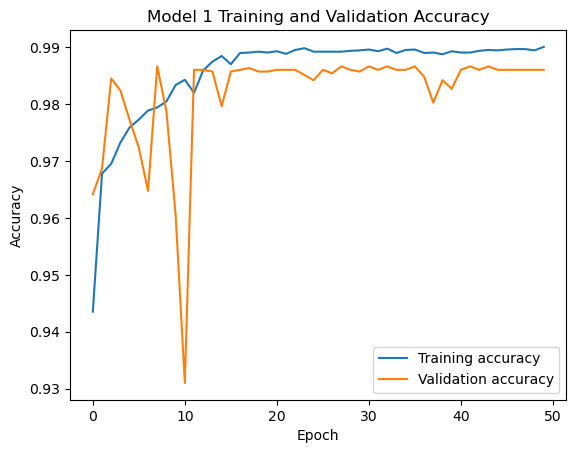

In [51]:
# plotting
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model 1 Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model 2 Creation and Evaluation

In [52]:
# making model 2 
model_2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# training model 2 
start_time = time.time()  # Start time for training
history_2 = model_2.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=10, verbose=1)
end_time = time.time()  # End time for training

Epoch 1/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.4723 - accuracy: 0.9408 - val_loss: 0.7441 - val_accuracy: 0.9383
Epoch 2/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.1366 - accuracy: 0.9685 - val_loss: 0.1221 - val_accuracy: 0.9675
Epoch 3/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.0896 - accuracy: 0.9764 - val_loss: 0.0635 - val_accuracy: 0.9860
Epoch 4/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.0603 - accuracy: 0.9831 - val_loss: 0.0668 - val_accuracy: 0.9815
Epoch 5/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.0627 - accuracy: 0.9838 - val_loss: 0.0627 - val_accuracy: 0.9833
Epoch 6/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.0628 - accuracy: 0.9833 - val_loss: 0.0628 - val_accuracy: 0.9815
Epoch 7/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.0537 - accuracy: 0.9868 - val_loss: 0.0537 - val_accuracy:

In [53]:
# calc and print the training time 
training_time_2 = end_time - start_time
print(f"Model 2 Training Time: {training_time_2:.2f} seconds")

Model 2 Training Time: 85.08 seconds


In [54]:
# eval model 2
test_loss_2, test_accuracy_2 = model_2.evaluate(X_test, y_test, verbose=1)
print(f"Model 2 Test Accuracy: {test_accuracy_2*100:.2f}%")

129/129 [==============================] - 0s 849us/step - loss: 0.0319 - accuracy: 0.9925
Model 2 Test Accuracy: 99.25%


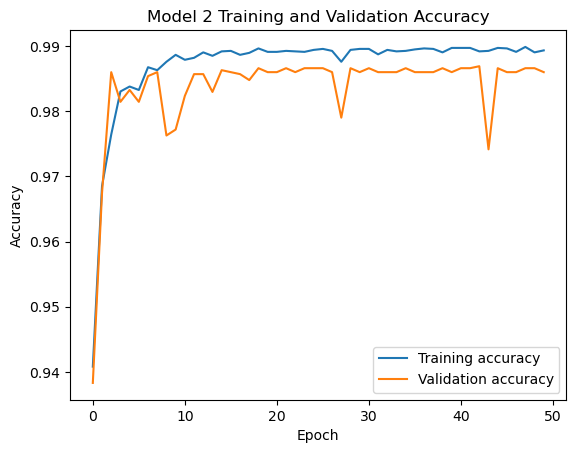

In [55]:
# plotting ltsm 2 
plt.plot(history_2.history['accuracy'], label='Training accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation accuracy')
plt.title('Model 2 Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model 3 Creation and Evaluation

In [56]:
# making the model 
model_3.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# traininig 
start_time_m3a = time.time()  # Start time for training
history_3 = model_3.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=10, verbose=1)
end_time_m3a = time.time()  # End time for training

Epoch 1/50
1316/1316 [==============================] - 3s 2ms/step - loss: 0.3570 - accuracy: 0.9485 - val_loss: 0.0910 - val_accuracy: 0.9657
Epoch 2/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.1008 - accuracy: 0.9717 - val_loss: 0.0670 - val_accuracy: 0.9815
Epoch 3/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.0838 - accuracy: 0.9760 - val_loss: 0.0725 - val_accuracy: 0.9784
Epoch 4/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.0633 - accuracy: 0.9843 - val_loss: 0.0641 - val_accuracy: 0.9742
Epoch 5/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.0685 - accuracy: 0.9817 - val_loss: 0.0676 - val_accuracy: 0.9784
Epoch 6/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.0575 - accuracy: 0.9856 - val_loss: 0.0672 - val_accuracy: 0.9702
Epoch 7/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.0658 - accuracy: 0.9821 - val_loss: 0.0521 - val_accuracy:

In [57]:
# calc and print the training time 
training_time_3 = end_time_m3a - start_time_m3a
print(f"Model 3 Training Time: {training_time_3:.2f} seconds")

Model 3 Training Time: 85.02 seconds


In [58]:
# eval model 3 
test_loss_3, test_accuracy_3 = model_3.evaluate(X_test, y_test, verbose=1)
print(f"Model 3 Test Accuracy: {test_accuracy_3*100:.2f}%")

129/129 [==============================] - 0s 1ms/step - loss: 0.0317 - accuracy: 0.9929
Model 3 Test Accuracy: 99.29%


In [59]:
# plotting
plt.plot(history_3.history['accuracy'], label='Training accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation accuracy')
plt.title('Model 3 Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

NameError: name 'history_3' is not defined

## Comparing all 3 of the Models against eachother 

NameError: name 'history_3' is not defined

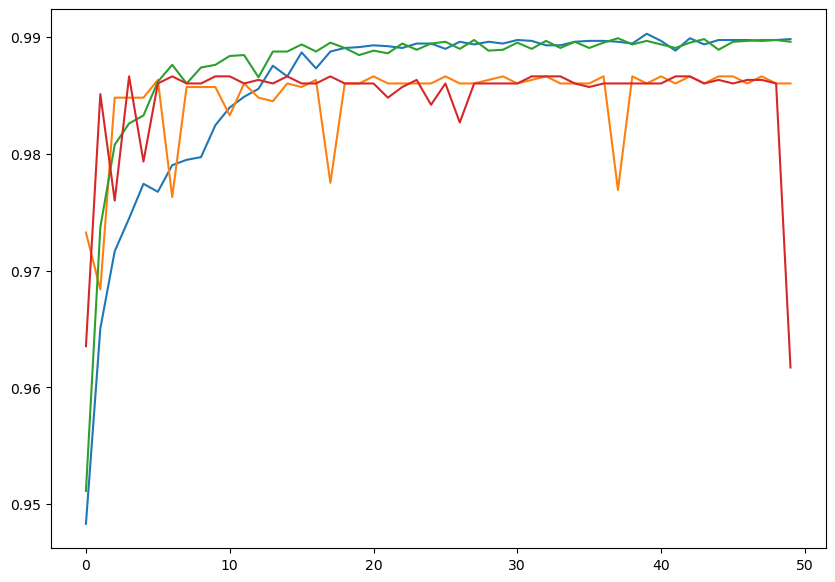

In [ ]:
# Charting 
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Model 1 Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Model 1 Validation Accuracy')
plt.plot(history_2.history['accuracy'], label='Model 2 Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Model 2 Validation Accuracy')
plt.plot(history_3.history['accuracy'], label='Model 3 Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Model 3 Validation Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model 3 had the best Training accuracy, and had the Validation. We are going to use model 3 to optimize and make perform better. Our best output was, 99.29% accurate. We are going to see if we can get that score even higher, just for the sake of optimization reasons. 

### Training with the SDG optimizer

In [ ]:
# re-doing model 3 with SDG optimizer
model_3_sgd = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile Model 3 
model_3_sgd.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
# training model 3 with SDG optimizer
history_3_sgd = model_3_sgd.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=10, verbose=1)

Epoch 1/50
1316/1316 [==============================] - 2s 1ms/step - loss: 1.1736 - accuracy: 0.7646 - val_loss: 0.5364 - val_accuracy: 0.7742
Epoch 2/50
1316/1316 [==============================] - 1s 1ms/step - loss: 0.5453 - accuracy: 0.7654 - val_loss: 0.5381 - val_accuracy: 0.7742
Epoch 3/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.5454 - accuracy: 0.7654 - val_loss: 0.5348 - val_accuracy: 0.7742
Epoch 4/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.5454 - accuracy: 0.7654 - val_loss: 0.5350 - val_accuracy: 0.7742
Epoch 5/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.5452 - accuracy: 0.7654 - val_loss: 0.5349 - val_accuracy: 0.7742
Epoch 6/50
1316/1316 [==============================] - 1s 1ms/step - loss: 0.5453 - accuracy: 0.7654 - val_loss: 0.5342 - val_accuracy: 0.7742
Epoch 7/50
1316/1316 [==============================] - 2s 1ms/step - loss: 0.5454 - accuracy: 0.7654 - val_loss: 0.5351 - val_accuracy:

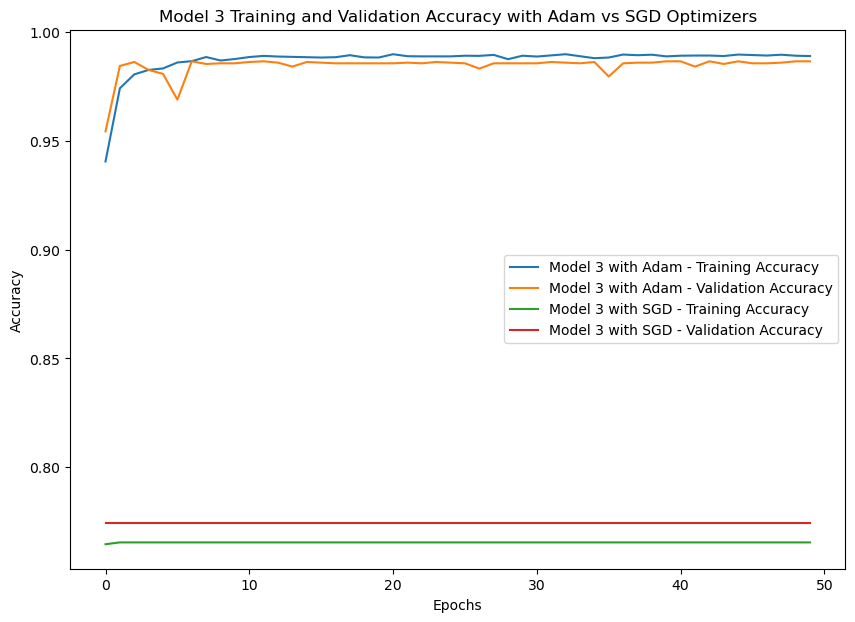

In [ ]:
# plotting the comparison
plt.figure(figsize=(10, 7))
plt.plot(history_3.history['accuracy'], label='Model 3 with Adam - Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Model 3 with Adam - Validation Accuracy')
plt.plot(history_3_sgd.history['accuracy'], label='Model 3 with SGD - Training Accuracy')
plt.plot(history_3_sgd.history['val_accuracy'], label='Model 3 with SGD - Validation Accuracy')
plt.title('Model 3 Training and Validation Accuracy with Adam vs SGD Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# creating a prediction column for the original data frame
df['Prediction'] = model_3.predict(X)
df.head()

643/643 [==============================] - 1s 872us/step


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,time,Temp_Hum_Ratio,DOTW,DOTW_encoded,Prediction
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,14:19:00,0.902101,Monday,1,0.962847
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,14:19:59,0.902168,Monday,1,0.962551
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,14:21:00,0.904689,Monday,1,0.962240
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,14:22:00,0.908038,Monday,1,0.944668
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,14:23:00,0.906641,Monday,1,0.942891


In [ ]:
# rounding the prediction column to 0 or 1
df['Prediction'] = df['Prediction'].round()

In [ ]:
# prinitng the coun tof the prediction column
df['Prediction'].value_counts()

Prediction
0.0    15628
1.0     4932
Name: count, dtype: int64

In [ ]:
# counting the actual values of the 'Occupancy' column
df['Occupancy'].value_counts()

Occupancy
0    15810
1     4750
Name: count, dtype: int64

In [ ]:
# saving the df back down to a csv file
df.to_csv('Occupancy_Predictions_LTSM_Model_3.csv', index=False)

In [ ]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,time,Temp_Hum_Ratio,DOTW,DOTW_encoded,Prediction
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,14:19:00,0.902101,Monday,1,1.0
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,14:19:59,0.902168,Monday,1,1.0
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,14:21:00,0.904689,Monday,1,1.0
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,14:22:00,0.908038,Monday,1,1.0
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,14:23:00,0.906641,Monday,1,1.0
